In [5]:
import cv2

video_path = "../video/2024_09_19__12_14_01.ts"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Errore: impossibile aprire il video.")
else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"FPS: {fps}")
    print(f"Totale frame: {total_frames}")

    # Calcolo il frame da estrarre a 0 minuti e 51 secondi
    target_time_sec = 1
    target_frame = int(fps * target_time_sec)

    if target_frame < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite("../images/frame_1sec.jpg", frame)
            print(f"Frame al secondo 51 (frame {target_frame}) salvato con successo.")
        else:
            print("Errore: lettura del frame fallita.")
    else:
        print(f"Errore: il video è troppo corto. Frame richiesto: {target_frame}, disponibili: {total_frames}")

cap.release()


FPS: 25.0
Totale frame: 4500
Frame al secondo 51 (frame 25) salvato con successo.


In [2]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import cProfile
import pstats
from io import StringIO

from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline_optimized as pipeline

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16 = DEVICE == "cuda"
USE_TORCH_COMPILE = DEVICE == "cuda" and hasattr(torch, 'compile')
COMPILE_MODE = "reduce-overhead"
N_INFERENCE_STEPS = 20
BATCH_SIZE_INPAINT = 4

print(f"[INFO] Using device: {DEVICE}")
print(f"[INFO] Using FP16 precision: {USE_FP16}")
print(f"[INFO] Using torch.compile: {USE_TORCH_COMPILE} (mode: {COMPILE_MODE})")
print(f"[INFO] Inpainting steps: {N_INFERENCE_STEPS}, batch size: {BATCH_SIZE_INPAINT}")

# === Paths ===
IMG_PATH = "../images/frame_1sec.jpg"
OUT_PATH = "../images/output_custom_inpainting_tot.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom_tot.csv"
MASK_OUT_PATH = "../mask/mask_car.jpg"
MODEL_DATA_DIR = "../data"
YOLO_MODEL_PATH = "yolov8x-seg.pt"

os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
os.makedirs(os.path.dirname(MASK_OUT_PATH), exist_ok=True)

# === Profilazione globale ===
pr = cProfile.Profile()
pr.enable()
start_total = time.time()

# === Load models ===
print("[INFO] Loading models...")
tokenizer = CLIPTokenizer(
    os.path.join(MODEL_DATA_DIR, "vocab.json"),
    merges_file=os.path.join(MODEL_DATA_DIR, "merges.txt")
)
model_file = os.path.join(MODEL_DATA_DIR, "v1-5-pruned-emaonly.ckpt")
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model checkpoint not found at {model_file}")

models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

for model_name in models:
    model = models[model_name]
    if model is not None:
        model.to(DEVICE)
        if USE_FP16:
            model.half()
        if USE_TORCH_COMPILE and model_name in ["encoder", "diffusion", "decoder"]:
            try:
                print(f"[INFO] Compiling {model_name}...")
                models[model_name] = torch.compile(model, mode=COMPILE_MODE)
            except Exception as e:
                print(f"[WARNING] Could not compile {model_name}: {e}")

# === Load image ===
if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image not found at {IMG_PATH}")
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === YOLOv8 segmentation ===
print("[INFO] Running YOLOv8 segmentation...")
if not os.path.exists(YOLO_MODEL_PATH):
    raise FileNotFoundError(f"YOLO model not found at {YOLO_MODEL_PATH}")
yolo_model = YOLO(YOLO_MODEL_PATH)
start_yolo = time.time()
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0
all_crops_data = []
full_mask = np.zeros((img_height, img_width), dtype=np.uint8)

# === Crop and Mask Extraction ===
start_crop = time.time()
for result in results:
    if result.masks is None:
        continue

    boxes = result.boxes
    masks_yolo = result.masks

    for i, cls_id in enumerate(boxes.cls):
        cls_id = int(cls_id)
        if cls_id not in [0, 2, 3, 7]:  # 0=person, 2=car, 3=motorbike, 7=truck
            continue

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks_yolo.data[i].cpu().numpy().astype(np.uint8)
        mask_resized_full = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

        contours, _ = cv2.findContours(mask_resized_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled_full_for_crop = np.zeros_like(mask_resized_full)
        cv2.drawContours(mask_filled_full_for_crop, contours, -1, 255, thickness=cv2.FILLED)

        full_mask = np.maximum(full_mask, mask_filled_full_for_crop)

        mask_crop_np = mask_filled_full_for_crop[y1:y2, x1:x2]
        if mask_crop_np.sum() / 255 < 200:
            continue

        crop_img_pil = original_img.crop((x1, y1, x2, y2))
        crop_mask_pil = Image.fromarray(mask_crop_np).convert("L")

        resized_img_pil = crop_img_pil.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask_pil = crop_mask_pil.resize((512, 512), resample=Image.Resampling.NEAREST)

        if cls_id == 0:
            prompt = "realistic person, same pose, same clothes, full body, high quality"
            negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"
        elif cls_id == 2:
            prompt = "realistic car, no license plate, no text, no numbers, no letters, same type, same angle"
            negative_prompt = "text, number, letter, symbol, logo, blur, distortion"
        elif cls_id == 3:
            prompt = "realistic motorbike, no license plate, same type, same angle, high quality"
            negative_prompt = "text, numbers, letters, cartoon, toy, unrealistic, distorted, glitch"
        elif cls_id == 7:
            prompt = "realistic truck, no license plate, no text, same type, same angle, high quality"
            negative_prompt = "text, number, letter, cartoon, unrealistic, glitch, logo"

        all_crops_data.append({
            'input_image': resized_img_pil,
            'input_mask': resized_mask_pil,
            'prompt': prompt,
            'negative_prompt': negative_prompt,
            'coords': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'box_w': box_w, 'box_h': box_h},
            'original_crop_pil': crop_img_pil,
            'blend_mask_pil': Image.fromarray(mask_crop_np).convert("L")
        })
crop_time = time.time() - start_crop

# === Save full mask ===
cv2.imwrite(MASK_OUT_PATH, full_mask)
print(f"[INFO] Full mask saved to: {MASK_OUT_PATH}")


Exception ignored When destroying _lsprof profiler:
Traceback (most recent call last):
  File "/tmp/ipykernel_349/2085176401.py", line 46, in <module>
RuntimeError: Cannot install a profile function while another profile function is being installed


[INFO] Using device: cuda
[INFO] Using FP16 precision: True
[INFO] Using torch.compile: True (mode: reduce-overhead)
[INFO] Inpainting steps: 20, batch size: 4
[INFO] Loading models...
[INFO] Compiling encoder...
[INFO] Compiling decoder...
[INFO] Compiling diffusion...
[INFO] Running YOLOv8 segmentation...
[INFO] Full mask saved to: ../mask/mask_car.jpg


🔍 PSNR: 28.34 dB
🔍 SSIM: 0.9139


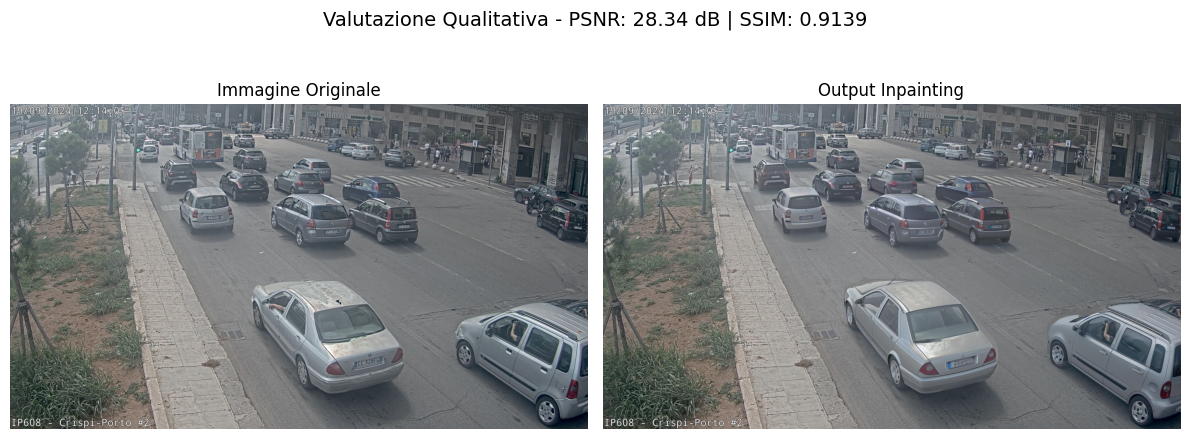

In [3]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Carica le immagini
original_img = np.array(Image.open(IMG_PATH).convert("RGB"))
inpainted_img = np.array(Image.open(OUT_PATH).convert("RGB"))

# Verifica dimensioni
assert original_img.shape == inpainted_img.shape, "Le immagini devono avere le stesse dimensioni"

# Calcolo delle metriche
psnr_value = psnr(original_img, inpainted_img, data_range=255)
ssim_value = ssim(original_img, inpainted_img, channel_axis=2, data_range=255)

print(f"🔍 PSNR: {psnr_value:.2f} dB")
print(f"🔍 SSIM: {ssim_value:.4f}")

# Plot per la tesi
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(original_img)
axs[0].set_title("Immagine Originale")
axs[0].axis("off")

axs[1].imshow(inpainted_img)
axs[1].set_title("Output Inpainting")
axs[1].axis("off")

plt.suptitle(f"Valutazione Qualitativa - PSNR: {psnr_value:.2f} dB | SSIM: {ssim_value:.4f}", fontsize=14)
plt.tight_layout()
plt.show()


In [4]:
import lpips
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# === Caricamento immagini come PIL ===
img1_pil = Image.open(IMG_PATH).convert("RGB")
img2_pil = Image.open(OUT_PATH).convert("RGB")

# === Preprocessing LPIPS ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # LPIPS expects input in range [-1, 1]
])

img1_tensor = transform(img1_pil).unsqueeze(0).to(DEVICE)
img2_tensor = transform(img2_pil).unsqueeze(0).to(DEVICE)

# === Calcolo LPIPS ===
loss_fn = lpips.LPIPS(net='alex').to(DEVICE)
lpips_score = loss_fn(img1_tensor, img2_tensor).item()

print(f"🔍 LPIPS (perceptual similarity): {lpips_score:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/vs/Projects/pytorch-stable-diffusion/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vs/Projects/pytorch-stable-diffusion/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/vs/Projects/pytorch-stable-diffusion/.venv/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
🔍 LPIPS (perceptual similarity): 0.0345


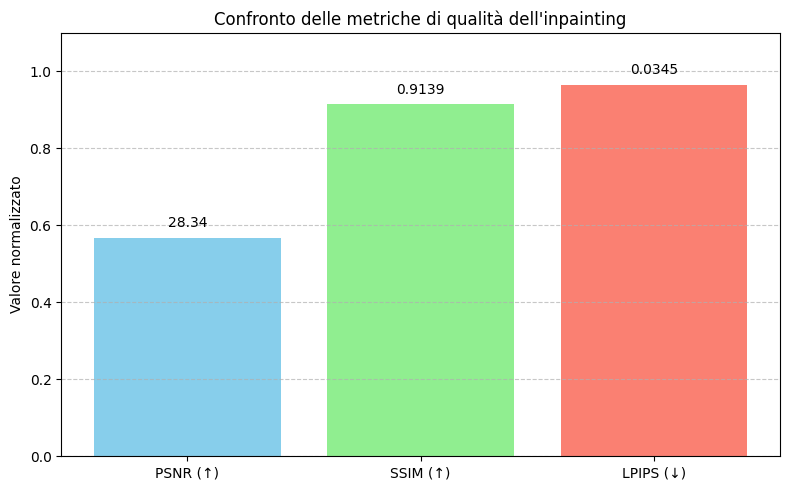

In [5]:
import matplotlib.pyplot as plt

# === Inserisci qui i tuoi valori ===
psnr_value = 28.34
ssim_value = 0.9139
lpips_value = 0.0345

# === Valori e nomi normalizzati per visualizzazione ===
metriche = ['PSNR (↑)', 'SSIM (↑)', 'LPIPS (↓)']
valori = [psnr_value / 50, ssim_value, 1 - lpips_value]  # Normalizzazione per confronto visivo

# === Grafico ===
plt.figure(figsize=(8, 5))
bars = plt.bar(metriche, valori, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.1)
plt.title("Confronto delle metriche di qualità dell'inpainting")
plt.ylabel("Valore normalizzato")

# Annotazioni sopra le barre
for bar, valore_originale in zip(bars, [psnr_value, ssim_value, lpips_value]):
    yval = bar.get_height()
    label = f"{valore_originale:.4f}" if valore_originale < 1 else f"{valore_originale:.2f}"
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, label, ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
